# 4. Metting the ML Model
Once the df is outliers-free and encoded, there are a couple of things we still have to deal with:
- **log-transform**: there are several variables highly skewed that require a log transform for improving the predictive accuracy.
- **Scaling and dealing with NaN's**: we normally deal with them earlier, but since we're using the KNN Imputer, we *needed every column to be numeric, scaled and encoded. With this method, we can analyze the nearest neighbors to every missing value to ponderate them and imput a value.
- **Feature importances**: to detect the most relevant variables when it comes to predicting the cars prices.

After that, we can find the best model by usign statistical metrics and fine-tune it to get the best performance possible.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("../data/data_encoded.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94128 entries, 0 to 94127
Data columns (total 69 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mileage_km                                94128 non-null  float64
 1   power_hp                                  94128 non-null  float64
 2   warranty_months                           87647 non-null  float64
 3   price                                     94128 non-null  float64
 4   length_mm                                 70369 non-null  float64
 5   width_mm                                  70522 non-null  float64
 6   height_mm                                 70358 non-null  float64
 7   wheelbase_mm                              70552 non-null  float64
 8   weight_kg                                 70552 non-null  float64
 9   engine_displacement_cm3                   70552 non-null  float64
 10  consumption_mixed_l_100km         

____________
## Applying log-transform
For those variables with high skewness, we should apply logarith transform. These variables are:

In [4]:
log_columns = ['price', 'power_hp', 'mileage_km', 'engine_displacement_cm3', 'co2_g_km']

In [5]:
for col in log_columns:
    df[f'log_{col}'] = np.log1p(df[col])

df.drop(columns=log_columns, inplace=True)

________________
## Data scaling and Missing values (NaN's)
Before imputing missing values with the KNNImputer, we have to scale the data. This is because the imputer uses the Euclidean distance to find the nearest neighbors, so we can't have variables in completely different scales (like price and car_age: the first one will dominate since the numbers are much bigger).

In this case, we're going to use StandardScaler(). There are many variables normally distributed, or at least, close to it, and it performs better with the KNN Imputer.

We first set a copy of the original df and initialize both the scaler and the imputer.

For simplicity, we're going to use only 2 neighbors.

In [6]:
df_scaled = df.copy()

st_scaler = StandardScaler()
imputer = KNNImputer(n_neighbors=2)

Then we scale and imput values.

In [ ]:
# first, we scale and then imput
scaled_array = st_scaler.fit_transform(df_scaled)
imputed_array = imputer.fit_transform(scaled_array)

# pass it to DF
df_scaled_imput = pd.DataFrame(imputed_array, index=df.index, columns=df.columns)

Now that we have the df imputed, we have to inverse the scaling. Why? Because for the imputation, it makes sense to scale the whole df together, since it uses Euclidian distance to calculate the nearest neighbor to every reading with missing values. However, when we later train the model, it's good to scale and train separately the features and the target to prevent data leakage that couls misslead the training process.

In [ ]:
# inverse scaling
df_imput = pd.DataFrame(st_scaler.inverse_transform(df_scaled_imput), index=df_scaled_imput.index, columns=df_scaled_imput.columns)

Store the scaled and imputed df

In [ ]:
df_imput.to_csv('../data/data_imputed.csv', index=False)

### **CHECK POINT
In case we want to load it and go on from here:

In [70]:
df_imput = pd.read_csv('../data/data_imputed.csv')

_______________________
## Feature importances
To better understand which variables contribute most to predicting car prices, we compute feature importances using a Random Forest model. This model evaluates how much each feature improves prediction performance when it's used in tree splits. By identifying the most influential variables, we can gain insights into the factors that most affect car pricing and potentially reduce dimensionality by focusing on the most relevant inputs. This step is crucial not only for model interpretability but also for enhancing the efficiency and performance of subsequent models trained on the selected features.

### X, y (independent variables and target) + Train/test split
First, we sort the target out from the independent variables and split the data in train and test sets:

In [71]:
X = df_imput.drop(columns=['log_price'])
y = df_imput['log_price']

X.shape, y.shape

((94128, 68), (94128,))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (75302, 68), y_train: (75302,)
X_test: (18826, 68),  y_test: (18826,)


Since we're using the Random Forest algorithm to determine the most important features, there is no need for scaling. This is because this algorithm makes decisions based on a threshold, not using a distance like, for example, we did earlier with the imputation. So, changing the scale would only imply to shift the threshold by the same scaling factor.

### Apply Random Forest for Feature Importances
We're going to apply a Random Forest to get the most contributing variables to the predictions. We can include a threshold: those with Importances less than 0.005 are not going to be considered, since less that that are likely noise and their going to need computational power that's better to focus on others.

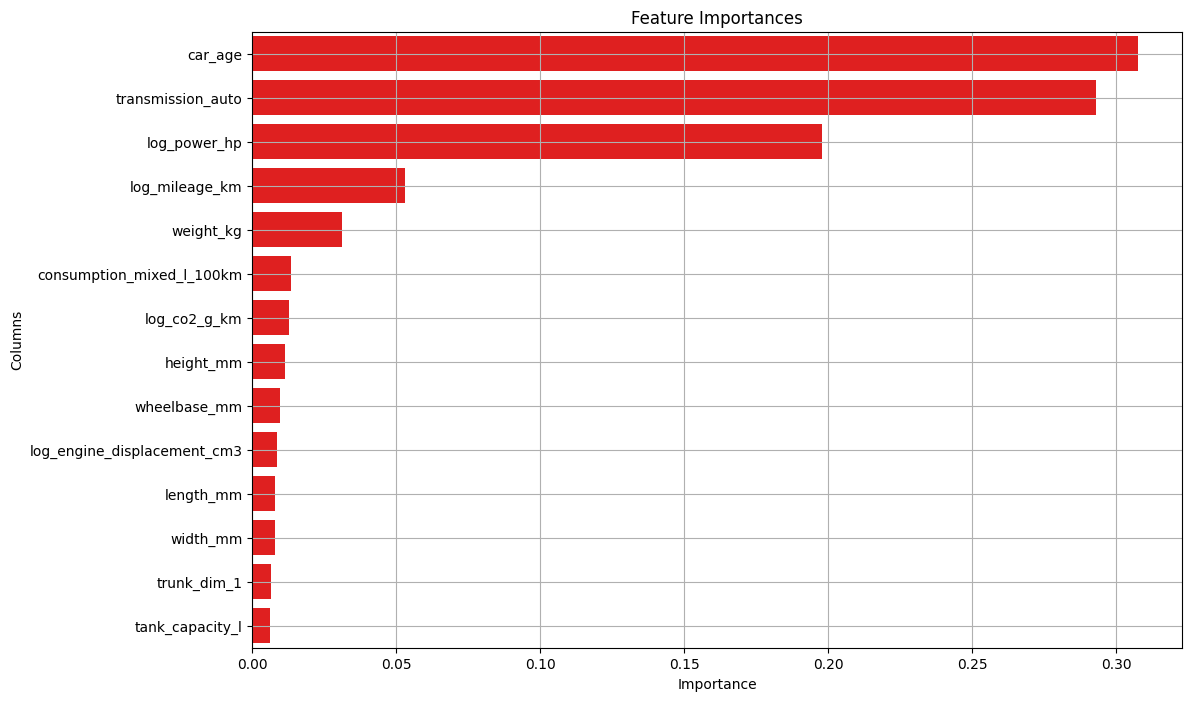

In [73]:
# declare the model
model = RandomForestRegressor(n_estimators= 100, random_state = 42)

# train the model 
model.fit(X_train, y_train)

# Compute Feature Importances
importances = model.feature_importances_

df_importances = pd.DataFrame({
    "Columns": X_train.columns, 
    "Importance": importances
    })

df_importances = df_importances[df_importances['Importance'] > 0.005].sort_values("Importance", ascending = False)

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importance"], y = df_importances["Columns"], color = "red")

plt.grid()
plt.show()

In [74]:
most_imp = df_importances['Columns'].tolist()
most_imp

['car_age',
 'transmission_auto',
 'log_power_hp',
 'log_mileage_km',
 'weight_kg',
 'consumption_mixed_l_100km',
 'log_co2_g_km',
 'height_mm',
 'wheelbase_mm',
 'log_engine_displacement_cm3',
 'length_mm',
 'width_mm',
 'trunk_dim_1',
 'tank_capacity_l']

### **CHECK POINT

In [75]:
Most_imp = ['car_age',
 'transmission_auto',
 'log_power_hp',
 'log_mileage_km',
 'weight_kg',
 'consumption_mixed_l_100km',
 'log_co2_g_km',
 'height_mm',
 'wheelbase_mm',
 'log_engine_displacement_cm3',
 'length_mm',
 'width_mm',
 'trunk_dim_1',
 'tank_capacity_l']

In [76]:
log_columns = [col for col in most_imp if 'log' in col]

____________________________
# Finding the best model
Now, we're going to try to find the model with the best performance when it comes to predict the cars prices. For that, we need to:
- Split the df into Train/test using the Features importances from the previous nb.
- Train the model using several algorithms.
- Define and get the metrics to evaluate each model's performance.
- Fine tune the best model hyperparameter using GridSearch.

In [92]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# we're using RandomizedSearch instead of GridSearch to speed up things
from sklearn.model_selection import RandomizedSearchCV

Since the dataset is sufficiently big to considerably slow down the cross validation, we're getting a 30% of the data to perform a Randomized Search Grid.

In [93]:
df_sample = df_imput.sample(frac=0.3, random_state=42)

Get the new X and y with only the most important features.

In [94]:
X = df_sample[most_imp]
y = df_sample['log_price']

X.shape, y.shape

((28238, 14), (28238,))

Train/Test split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (22590, 14), y_train: (22590,)
X_test: (5648, 14),  y_test: (5648,)


Scale the features and the target independently to avoid data leakage. 

As we can see here, we use fit_transform only on the training set, so the model can learn the minimum and maximum values from the fit function. In this way:
- we will be applying the same scaling on the test set. 
- preventing data leakage since the model gets this data from the training set without seeing anything from the test.

In [96]:
scaler_x = MinMaxScaler()
x_train_scaled = scaler_x.fit_transform(X_train)
x_test_scaled = scaler_x.transform(X_test)

In [97]:
scaler_y = MinMaxScaler()
# .values transforms the df column into a Numpy array and reshape(-1, 1) gives it 2D, needed for the fit_transform
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

Next, we import the model we're going to train.

In [98]:
models = [LinearRegression(), RandomForestRegressor(), DecisionTreeRegressor(), 
          KNeighborsRegressor(), AdaBoostRegressor(), GradientBoostingRegressor()]

model_names = ["LinearRegression", "RandomForest", "DecisionTree",'KNeighborsRegressor', "AdaBoostRegressor", "GradientBoosting"]

### Models evaluation
The models are going to be evaluated using the typical metrics for regression problems like this one:
- Mean Absolute Error (MAE).
- Root Mean Squared Error (RMSE).
- R² Score.

For that, we're going to build a function to test all the models and get their performances. The decision of which one should we use is going to be based specially on the R² Score, since it gives the model's overall performance, but paying attention to the others.

In [99]:
def metrics(df_metrics, model, model_name, X_train, X_test, y_train_log_scaled, y_test_log_scaled, scaler_y):

    print(f"Training model... Now: {model_name}")

    # train the model 
    model.fit(X_train, y_train_log_scaled.ravel())

    # predictions
    y_pred_log_scaled = model.predict(X_test)

    # inverse scaling 
    y_pred_log = scaler_y.inverse_transform(y_pred_log_scaled.reshape(-1, 1)).flatten()
    y_test_log = scaler_y.inverse_transform(y_test_log_scaled.reshape(-1, 1)).flatten()

    # inverse log1p 
    y_pred = np.expm1(y_pred_log)
    y_test = np.expm1(y_test_log)

    # print(y_pred.shape)
    # print(y_test.shape)

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    df_metrics.loc[len(df_metrics)] = [model_name, mae, rmse, r2]
    
    return df_metrics

In [100]:
df_metrics = pd.DataFrame(columns=["Model", "MAE", "RMSE", "R2_score"])

for model, model_name in zip(models, model_names):
    df_performance = metrics(df_metrics, model, model_name, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, scaler_y)

Training model... Now: LinearRegression
Training model... Now: RandomForest
Training model... Now: DecisionTree
Training model... Now: KNeighborsRegressor
Training model... Now: AdaBoostRegressor
Training model... Now: GradientBoosting


In [101]:
df_performance.sort_values(by='R2_score', ascending=False, inplace=True)
df_performance.reset_index(drop=True, inplace=True)

In [102]:
df_performance

,Model,MAE,RMSE,R2_score
0,RandomForest,2298.811179,1.711910e+07,0.884569
1,KNeighborsRegressor,2680.979607,2.134814e+07,0.856054
2,GradientBoosting,3063.430201,2.362529e+07,0.840700
3,DecisionTree,3027.162971,3.059390e+07,0.793712
4,LinearRegression,3766.432280,3.500457e+07,0.763971
5,AdaBoostRegressor,4813.023897,5.392583e+07,0.636389


Clearly, the Random Forsest has the best performance here, closely followed by the KNeighbors. Also the DesicionTree and the Gradient Boosting have a good R2 score, so it would worth to give them a shot when tunning hyperparameters.

On the other hand, Ada Boost had the worst performance. Also, the non linearity of this specific problem could cause a lower performance of the Linear Regressor.

_____________
## Hyperparameter tuning
To achive the best performance with the best models so far, we need to use techniques such as GridSearch to look for the best combination of hyperparameters for the models.

In [103]:
# models to be tested
models = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
]

model_names = ["RandomForest", "DecisionTree", "KNeighborsRegressor", "GradientBoosting"]

In [104]:
# Models and hyperparameters
param_grids = {
    "RandomForest": {
          "n_estimators"           : [100, 200], 
          "criterion"              : ['absolute_error'], 
          "max_features"           : ["sqrt"],
          "min_samples_split"      : [5, 10], 
          "random_state"           : [42],
      #     "max_depth"              : [None, 10, 20]
          },
    "DecisionTree": {
          "criterion"              : ['absolute_error'], 
          "max_features"           : ["sqrt", "log2"], 
          "min_samples_split"      : [5, 10], 
          "random_state"           : [42],
      #     "max_depth"              : [None, 10, 20]
          },
    "KNeighborsRegressor": {"n_neighbors": [3, 4, 5, 6], "weights": ["uniform", "distance"], "p": [1, 2]},
    "GradientBoosting": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 5], "subsample": [0.8, 1.0]},
}

In [105]:
def run_gridsearch_and_evaluate(models, model_names, param_grids, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_y):

    df_results = pd.DataFrame(columns=["model_name", "best_params", "mae", "mse", "r2_score"])

    for model_name, model in zip(model_names, models):
        print(f"Training {model_name}...")

        # Get parameter grid
        param_grid = param_grids.get(model_name, {})

        # Grid search
        search = RandomizedSearchCV(model, param_grid, cv=2, scoring="r2", n_jobs=-1)
        search.fit(X_train_scaled, y_train_scaled.ravel())

        best_model = search.best_estimator_
        best_params = search.best_params_

        # Predict in scaled log space
        y_pred_scaled = best_model.predict(X_test_scaled)

        # Inverse scaling: there's still log applied!!
        y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_test_log = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

        # Inverse log transform
        y_pred = np.expm1(y_pred_log)
        y_test = np.expm1(y_test_log)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save results
        df_results.loc[len(df_results)] = [model_name, best_params, mae, mse, r2]

    return df_results


In [106]:
df_results_grid = run_gridsearch_and_evaluate(models, model_names, param_grids, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, scaler_y)

Training RandomForest...


c:\Users\armej\OneDrive\Documentos\DS_Projects\Cars_Prices_Predictive_Modelling\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training DecisionTree...


c:\Users\armej\OneDrive\Documentos\DS_Projects\Cars_Prices_Predictive_Modelling\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training KNeighborsRegressor...
Training GradientBoosting...


## Model selection
The R² score is very similar on the top 3. Which one should we choose? In this case, we're moving on with the RandomForest because:
- It's slightly more accurate in MAE, meaning that it has the lowest average error, while the R² difference with GradientBoosting is negligible.
- It's faster to train, easier to explain (feature importance), and more robust across various data types.

In [108]:
df_results_grid.sort_values(by="r2_score", ascending=False).reset_index(drop=True)

,model_name,best_params,mae,mse,r2_score
0,GradientBoosting,"{'subsample': 0.8, 'n_estimators': 200, 'max_d...",2492.148994,1.696194e+07,0.885629
1,RandomForest,"{'random_state': 42, 'n_estimators': 200, 'min...",2254.758853,1.708822e+07,0.884778
2,KNeighborsRegressor,"{'weights': 'distance', 'p': 1, 'n_neighbors': 6}",2327.035908,1.812434e+07,0.877791
3,DecisionTree,"{'random_state': 42, 'min_samples_split': 5, '...",3111.272242,3.174046e+07,0.785981
